In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F

In [2]:
text = open('shakespeare.txt', 'r').read()
stoi = {ch: i for i, ch in enumerate(sorted(list(set(text))))}
itos = {i: ch for ch, i in stoi.items()}
encode = lambda s: [stoi[c] for c in s]
decode = lambda l: ''.join([itos[i] for i in l])
vcb = len(stoi)
print(f"Vocab length is : {vcb}")
import random

class dataloader:
    def __init__(self):
        self.data = torch.tensor(encode(text))
        self.train_counter = 0
        self.val_counter = 0
    def next_batch(self, dataset):
        n = int(len(self.data) * 0.9)
        xt = self.data[self.train_counter:84000 + self.train_counter].view(-1, 100)
        yt = self.data[1 + self.train_counter:84001 + self.train_counter].view(-1, 100)
        xv = self.data[self.val_counter + 84000:self.val_counter + 94000].view(-1, 100)
        yv = self.data[self.val_counter + 84001:self.val_counter + 94001].view(-1, 100)
        if dataset == 'train':
            self.train_counter += random.randint(1, 100)
            if self.train_counter + len(self.data) >= 84000:
                self.train_counter = 0
            return xt, yt
        elif dataset == 'val':
            self.val_counter += random.randint(1, 100)
            if self.val_counter + len(self.data) >= 94000:
                self.val_counter = 0
            return xv, yv
        else:
            raise Exception("Invalid dataset")
print(stoi, itos)

Vocab length is : 61
{'\n': 0, ' ': 1, '!': 2, "'": 3, '(': 4, ')': 5, ',': 6, '-': 7, '.': 8, ':': 9, ';': 10, '?': 11, 'A': 12, 'B': 13, 'C': 14, 'D': 15, 'E': 16, 'F': 17, 'G': 18, 'H': 19, 'I': 20, 'J': 21, 'K': 22, 'L': 23, 'M': 24, 'N': 25, 'O': 26, 'P': 27, 'R': 28, 'S': 29, 'T': 30, 'U': 31, 'V': 32, 'W': 33, 'Y': 34, 'a': 35, 'b': 36, 'c': 37, 'd': 38, 'e': 39, 'f': 40, 'g': 41, 'h': 42, 'i': 43, 'j': 44, 'k': 45, 'l': 46, 'm': 47, 'n': 48, 'o': 49, 'p': 50, 'q': 51, 'r': 52, 's': 53, 't': 54, 'u': 55, 'v': 56, 'w': 57, 'x': 58, 'y': 59, 'z': 60} {0: '\n', 1: ' ', 2: '!', 3: "'", 4: '(', 5: ')', 6: ',', 7: '-', 8: '.', 9: ':', 10: ';', 11: '?', 12: 'A', 13: 'B', 14: 'C', 15: 'D', 16: 'E', 17: 'F', 18: 'G', 19: 'H', 20: 'I', 21: 'J', 22: 'K', 23: 'L', 24: 'M', 25: 'N', 26: 'O', 27: 'P', 28: 'R', 29: 'S', 30: 'T', 31: 'U', 32: 'V', 33: 'W', 34: 'Y', 35: 'a', 36: 'b', 37: 'c', 38: 'd', 39: 'e', 40: 'f', 41: 'g', 42: 'h', 43: 'i', 44: 'j', 45: 'k', 46: 'l', 47: 'm', 48: 'n', 49: '

In [3]:
torch.tensor(encode(text)).shape

torch.Size([94275])

In [4]:
from dataclasses import dataclass
@dataclass
class Config:
    n_embd = 256
    hidden_size = 512
    n_hidden = 3
    vocab_size = 61
    device = 'cuda' if torch.cuda.is_available() else 'cpu'

class ShakespeareRNN(nn.Module):
    def __init__(self, config):
        super(ShakespeareRNN, self).__init__()
        self.config = config
        self.embedding = nn.Embedding(config.vocab_size, config.n_embd)
        self.RNN = nn.ModuleDict(dict(
            inputs = nn.Linear(config.n_embd, config.hidden_size),
            hidden = nn.Linear(config.hidden_size, config.hidden_size),
            hidden2 = nn.Linear(config.hidden_size, config.hidden_size),
            hidden3 = nn.Linear(config.hidden_size, config.hidden_size),
            output = nn.Linear(config.hidden_size, config.vocab_size)
        ))
    def forward(self, x, hidden_state, target=None):
        x = self.embedding(x)
        x = F.gelu(self.RNN['inputs'](x) + self.RNN['hidden'](hidden_state))
        x = x + F.gelu(self.RNN['hidden2'](x))
        x = x + F.gelu(self.RNN['hidden3'](x))
        hidden_state = x
        output = self.RNN['output'](x)
        loss = None
        if target is not None:
            loss = F.cross_entropy(output, target)
        return output, hidden_state, loss

In [5]:
# prompt: Cosine learning rate decay function
import math

def cosine_lr_decay(optimizer, step, total_steps, lr_max, lr_min):
    """
    Cosine learning rate decay function.

    Args:
        optimizer: The optimizer whose learning rate is to be decayed.
        step: The current training step.
        total_steps: The total number of training steps.
        lr_max: The maximum learning rate.
        lr_min: The minimum learning rate.

    Returns:
        None
    """
    progress = step / total_steps
    lr = lr_min + (lr_max - lr_min) * (0.5 * (1 + math.cos(progress * math.pi)))
    return lr


In [6]:
model = ShakespeareRNN(Config()).to(Config().device)
num_params = sum(p.numel() for p in model.parameters())
print(f"The number of parameters in the model is: {num_params}")

The number of parameters in the model is: 966461


In [7]:
# training
num_epochs = 3000
dl = dataloader()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
first_hidden  = torch.zeros(1, model.config.hidden_size).to(model.config.device)
hidden_state = first_hidden
tlossi = []
vlossi = []
lri = []
gradients = []
for epoch in range(num_epochs):
    x, y = dl.next_batch('train')
    xv, yv = dl.next_batch('val')
    x, y = x.to(model.config.device), y.to(model.config.device)
    xv, yv = xv.to(model.config.device), yv.to(model.config.device)
    total_loss = 0
    val_loss = 0
    epoch_loss = 0
    lr = cosine_lr_decay(optimizer, epoch, num_epochs, 0.001, 0.00001)
    # lr = 0.0001
    lri.append(lr)
    for i in range(100):
        hidden_state = hidden_state.detach()
        output, hidden_state, loss = model(x[:, i], hidden_state=hidden_state, target=y[:, i])
        for param_group in optimizer.param_groups:
            param_group['lr'] = lr
        optimizer.zero_grad()
        loss.backward()
        # gradient clipping
        nn.utils.clip_grad_norm_(model.parameters(), 1)
        total_loss += loss.item()
        epoch_loss += loss.item()
        optimizer.step()
        interval = 50
        if (i + 1) % interval == 0 and i != 0:
            tlossi.append(total_loss/(interval))
            total_loss = 0
        if epoch % 100 == 0 and i == 99:
            with torch.no_grad():
                val_hidden = torch.zeros(1, model.config.hidden_size).to(model.config.device)
                for j in range(100):
                    val_hidden = val_hidden.detach()
                    output, val_hidden, loss = model(xv[:, j], hidden_state=val_hidden, target=yv[:, j])
                    val_loss += loss.item()
                print(f"Epoch: [{epoch}/{num_epochs}], Loss: {epoch_loss/100}, Val Loss: {val_loss/100}") 
                vlossi.append(val_loss/100)
        total_grad_norm_squared = 0
        for param in model.parameters():
            if param.grad is not None:
                grad_norm_squared = torch.sum(param.grad ** 2)
                total_grad_norm_squared += grad_norm_squared
        total_grad_norm = total_grad_norm_squared.sqrt().item()
        gradients.append(total_grad_norm)
        
torch.save(model.state_dict(), 'shakespeare_rnn_3000_3r_res_1m.pth')                            


Epoch: [0/3000], Loss: 2.268352507352829, Val Loss: 1.9106521093845368
Epoch: [100/3000], Loss: 1.1352999180555343, Val Loss: 2.070452616214752
Epoch: [200/3000], Loss: 1.076314741373062, Val Loss: 2.3088936495780943
Epoch: [300/3000], Loss: 1.0381871038675308, Val Loss: 2.333832850456238
Epoch: [400/3000], Loss: 1.0257850539684297, Val Loss: 2.346718285083771
Epoch: [500/3000], Loss: 0.9982595890760422, Val Loss: 2.439258476495743
Epoch: [600/3000], Loss: 0.978696905374527, Val Loss: 2.4511160027980803
Epoch: [700/3000], Loss: 0.9535985660552978, Val Loss: 2.554341630935669
Epoch: [800/3000], Loss: 0.9282117390632629, Val Loss: 2.589925948381424
Epoch: [900/3000], Loss: 0.9032047098875046, Val Loss: 2.660477876663208
Epoch: [1000/3000], Loss: 0.8880662375688553, Val Loss: 2.6788816404342652
Epoch: [1100/3000], Loss: 0.8575604856014252, Val Loss: 2.7501745557785036
Epoch: [1200/3000], Loss: 0.8405070346593857, Val Loss: 2.8059444427490234
Epoch: [1300/3000], Loss: 0.8075519415736199, V

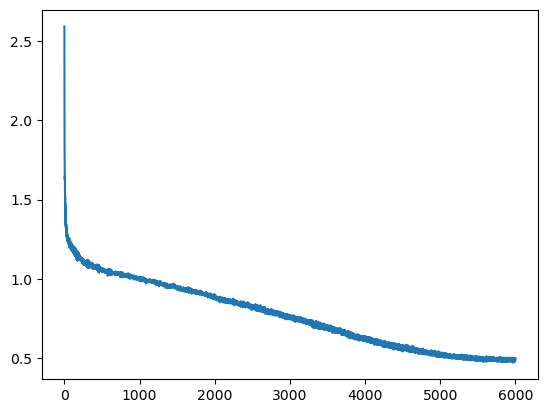

Min tes loss: 0.47102188974618914
Fin tes loss: 0.49916060090065
Min val loss: 1.9106521093845368
Fin val loss: 4.095321617126465


In [8]:
import matplotlib.pyplot as plt
plt.plot((tlossi[:]))
# clipped_lossi = []
# for l in tlossi:
#     if l < 3:
#         clipped_lossi.append(l)
# plt.plot(clipped_lossi)
plt.show()
print(f"Min tes loss: {min(tlossi)}")
print(f"Fin tes loss: {tlossi[-1]}")
print(f"Min val loss: {min(vlossi)}")
print(f"Fin val loss: {vlossi[-1]}")

When ran with 1000 epochs without residuals the min loss was: 1.612 \
When ran with 1000 epochs with residuals the min loss was: 1.601 \
When ran with 2000 epochs with residuals the min loss was: 1.589 \
note* while looking at the loss graph it seems like the loss can continue to decrease with this setup and more epochs \
When ran with 2000 epochs with residuals and two hidden layers the min loss was: 1.529 \
First going to get the val loss for this run and see how it is \
The same test with val loss now being calculated. MIN Tloss: 1.516 MIN VLoss: 1.826 \
\
To test the impact of residuals I'm going to remove them here and see how that affects the performance \
No Residuals: MIN TLoss: 1.516 MIN VLoss: 1.826 \
\
Making the model more parameters and deeper from 20000 params to 700000 and gradient clipping\
old, n_embd=64 n_hidden=64 \
new, n_embd=256 n_hidden = 512 \
New test with 2000 epochs, MIN TLoss: 1.377 FIN VLoss: 2.778 \ 
\
Final test for now \
1 million param, 3 hidden, 3k epochs, p.s. found a bug in the model so everything before is a little weird \
MIN TLoss: 0.471 FIN VLoss: 4.09 \
So this is obviosly just memorizing the dataset at this point and the limits of char NLP is evident


In [13]:
# model testing


hidden_state = torch.zeros(1, model.config.hidden_size).to(model.config.device)
output = torch.tensor([20]).to(model.config.device)
print(itos[20], end='')
response_length = 900
for _ in range(response_length):
    output, hidden_state, loss = model(output, hidden_state=hidden_state)
    probs = F.softmax(output.view(1, -1), dim=1)
    output = torch.multinomial(probs, num_samples=1)
    print(itos[int(output.item())], end='')

I sense of my love, to whom I am not born to out in your true love of young.
Thus have return in your perfumed the herd
As a death my days should it depends of blood warmion this glutton by your shadow kind,
Harsh, still without all deeds must I under than a for nor than of my brain
Full change into my deeds thee,
This sin there beauty being made)
Shall beauty was every alien pen hath more enlarged hooks of the blind do not summer's shope to present'st friend's oppress hhants by.



Since first the world will be the mortal wanting youth, some into my beloved, yet where thou art.
Gen but one, and the read fleece tang a number on me thought
To think of them me well proud of agers with flower from Time's quicked the clock that thou for worthiness give them thy mother;  
Withister still,
Which through him be grieved that flowers I better becomimy profitless usurer weeds.



For walks treads w